# Finding Donors for *CharityML* - Supervised Learning

## Project Overview

In this project, I will employ several supervised algorithms to accurately model individuals' income using data collected from the 1994 U.S. Census. I will choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. 

The goal of this project is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

----
## Exploring the Data
`income` will be the target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("data/census.csv")

# Success - Display the first record
display(data.head(n=1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


In [2]:
# Total number of records
n_records = data.shape[0]

# Number of records where individual's income is more than $50,000
n_greater_50k = data['income'].value_counts()['>50K']

# Number of records where individual's income is at most $50,000
n_at_most_50k = data['income'].value_counts()['<=50K']

# Percentage of individuals whose income is more than $50,000
greater_percent = 100.0 * n_greater_50k / n_records

print("Total number of records: {}".format(n_records))
print("Individuals making more than $50,000: {}".format(n_greater_50k))
print("Individuals making at most $50,000: {}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {}%".format(greater_percent))

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78439697492371%


**Featureset Exploration**

* **age**: continuous. 
* **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
* **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
* **education-num**: continuous. 
* **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
* **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
* **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
* **race**: Black, White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other. 
* **sex**: Female, Male. 
* **capital-gain**: continuous. 
* **capital-loss**: continuous. 
* **hours-per-week**: continuous. 
* **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

----
## Data Preprocessing
Missing values have already been removed.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

Run the code cell below to plot a histogram of these two features. Note the range of the values present and how they are distributed.

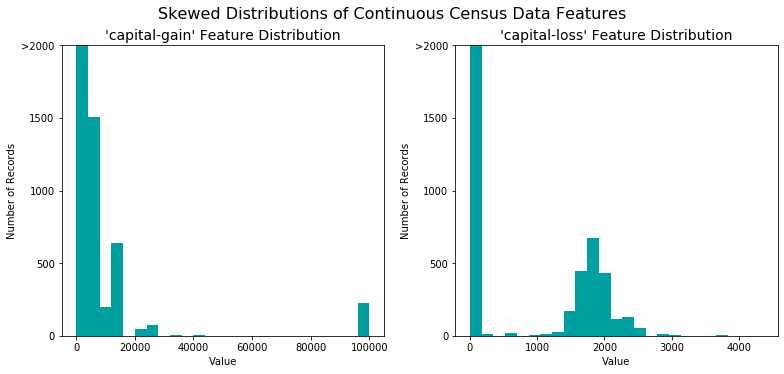

In [3]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, we could consider applying log transformation on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

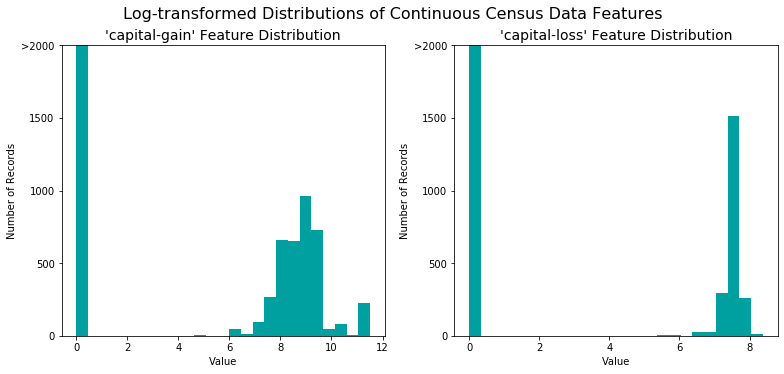

In [4]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_log_transformed, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, I'm going to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution, but normalization ensures that each feature is treated equally when applying supervised learners. 

In [5]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# Show an example of a record with scaling applied
display(features_log_minmax_transform.head(n = 5))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


### One-hot Encoding for categorical features

In [6]:
# One-hot encode the 'features_log_minmax_transform' data using pandas.get_dummies()
features_final = pd.get_dummies(features_log_minmax_transform)

# Encode the 'income_raw' data to numerical values
income = pd.get_dummies(income_raw)['>50K']

# Print the number of features after one-hot encoding
encoded = list(features_final.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))

103 total features after one-hot encoding.


### Shuffle and Split Data
80% of the data will be used for training and 20% for testing.

In [7]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, income, test_size = 0.2, random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


----
## Evaluating Model Performance

### Metrics and the Naive Predictor

**Accuracy** measures how often the classifier makes the correct prediction. It’s the ratio of the number of correct predictions to the total number of predictions (the number of test data points).

**Precision** tells us what proportion of messages we classified as spam, actually were spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all positives(all words classified as spam, irrespective of whether that was the correct classificatio), in other words it is the ratio of

`[True Positives/(True Positives + False Positives)]`

**Recall(sensitivity)** tells us what proportion of messages that actually were spam were classified by us as spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all the words that were actually spam, in other words it is the ratio of

`[True Positives/(True Positives + False Negatives)]`

In this case I will use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

In [8]:
TP = np.sum(income)
FP = income.count() - TP

TN = 0 
FN = 0 

# Calculate accuracy, precision and recall
accuracy = float((TP + TN) / (TP + FP + TN + FN))
recall = float(TP / (TP + FN))
precision = float(TP / (TP + FP))

# Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
beta = 0.5
fscore = (1 + np.power(beta, 2)) * (precision * recall) / (np.power(beta, 2) * (precision + recall))

# Print the results 
print("Naive Predictor: [Accuracy score: {:.4}, F-score: {:.4}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.9931]


###  Supervised Learning Models
Available choices:
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Question 2 - Model Application
List three of the supervised learning models above that are appropriate for this problem that you will test on the census data. For each model chosen

- Describe one real-world application in industry where the model can be applied. 
- What are the strengths of the model; when does it perform well?
- What are the weaknesses of the model; when does it perform poorly?
- What makes this model a good candidate for the problem, given what you know about the data?

** HINT: **

Structure your answer in the same format as above^, with 4 parts for each of the three models you pick. Please include references with your answer.

**Logistic Regression**
 - Real-world application: To predict if a patient got cancer given the demographic and medical information.
 - Strengths of the model:
   - 1) Outputs have a nice probabilistic interpretation.
   - 2) The algorithm can be regularized to avoid overfitting compared to linear regression.
   - 3) Logistic models can be updated easily with new data using stochastic gradient descent.
 - Weaknesses of the model:
   - 1) Logistic regression tends to underperform when there are multiple or non-linear decision boundaries. They are not flexible enough to naturally capture more complex relationships.
 - For this problem: Logistic regression is used to predict binary classes. In this case, we are going to predicit if the donors has income larger than 50,000 (labeled 1)or lower than or equal to 50,000(labeled 2). Especially it's sparse data with 25% individuals have income  >50k and 75% individuals have income <= 50k, the logistic regression is a good choice.
   
**Decision Tree**
 - Real-world application: To predict if an Instagram account is a fake account.
 - Strengths of the model:
   - 1) Decision Trees are easy to explain. It results in a set of rules.
   - 2) It follows the same approach as humans generally follow while making decisions.
   - 3) Interpretation of a complex Decision Tree model can be simplified by its visualizations.
   - 4) The Number of hyper-parameters to be tuned is almost null.
 - Weaknesses of the model:
   - 1) They can be extremely sensitive to small perturbations in the data: a slight change can result in a drastically different tree.
   - 2) It has a high probability of overfitting. This can be negated by validation methods and pruning.
   - 3) They can have problems out-of-sample prediction (this is related to them being non-smooth).
 - For this problem: Decision tree model is a good tool for classification. It has higher accuracy than the regression models.

**Random Forest**
 - Real-world application: To predict if a customer is going to churn or not based on the user data.
 - Strengths of the model:
   - 1) Compare to decision tree model, it could drastically decrease the probability of overfitting. The process of averaging or combining the results of different decision trees helps to overcome the problem of overfitting.
   - 2) Random forests also have less variance than a single decision tree. It means that it works correctly for a large range of data items than single decision trees.
   - 3) Random forests are extremely flexible and have very high accuracy.
   - 4) It do not require preparation of the input data. You do not have to scale the data.
   - 5) It also maintains accuracy even when a large proportion of the data are missing.
 - Weaknesses of the model:
   - 1) The main disadvantage of Random forests is their complexity. They are much harder and time-consuming to construct than decision trees.
   - 2) They also require more computational resources and are also less intuitive. When you have a large collection of decision trees it is hard to have an intuitive grasp of the relationship existing in the input data.
   - 3) The prediction process using random forests is time-consuming than other algorithms.
 - For this problem: Since we have around 40k data, it's good to use Random Forest model to do prediction with higher accuracy. It could also deal with the problem of overfitting. It's not big data more than 100k so it will not be so time-consuming.

### Implementation - Training and Predicting Pipeline

In [9]:
# Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import fbeta_score, accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end - start
        
    # Get the predictions on the test set(X_test), 
    # then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train)
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end - start
            
    # Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train[:300])
        
    # Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[:300], predictions_train[:300], beta = 0.5)
        
    # Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test, predictions_test, beta = 0.5)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

### Implementation - Initial Model Evaluation

DecisionTreeClassifier trained on 361 samples.
DecisionTreeClassifier trained on 3617 samples.
DecisionTreeClassifier trained on 36177 samples.
RandomForestClassifier trained on 361 samples.
RandomForestClassifier trained on 3617 samples.
RandomForestClassifier trained on 36177 samples.
GradientBoostingClassifier trained on 361 samples.
GradientBoostingClassifier trained on 3617 samples.
GradientBoostingClassifier trained on 36177 samples.


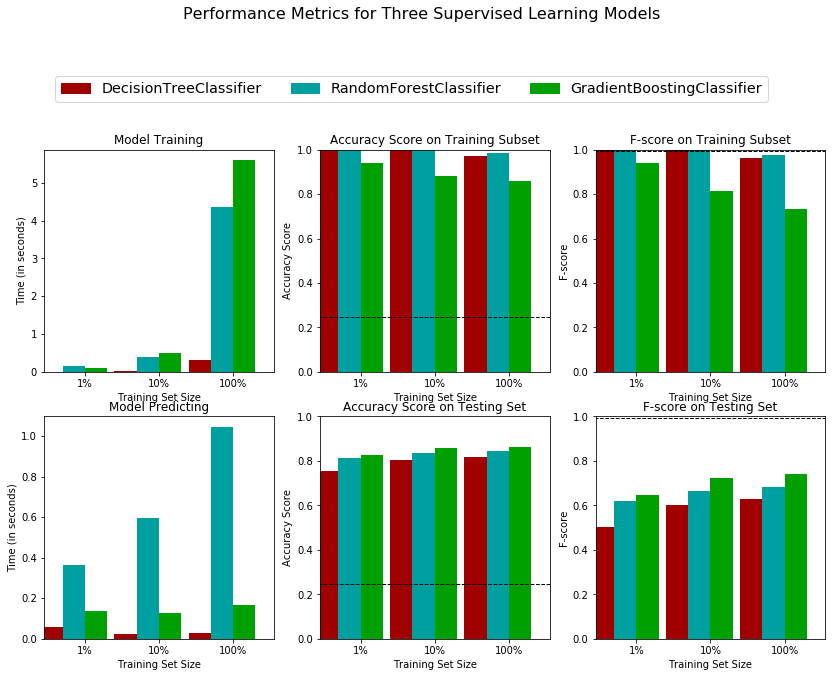

In [10]:
# Import the supervised learning models from sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Initialize the models
clf_A = DecisionTreeClassifier()
clf_B = RandomForestClassifier()
clf_C = GradientBoostingClassifier()

clfList = [clf_A, clf_B, clf_C]

samples_100 = len(y_train)
samples_10 = int(0.1 * len(y_train))
samples_1 = int(0.01 * len(y_train))

# Collect results on the learners
results = {}
for clf in clfList:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

The Gradient Boosting model has the highest score, with F-score of 0.74, training time of 0.11. Though the training time is longer than the other ones, it maintains a high accuracy and F-score. As 0.11 is considered accepetable and we would like to get a better model performance, the Gradient Boosting is the most suitable one for this case.

When the Gradient boosting works, we have a loss function to be optimized. Decision trees are chosen as the weak learnerweak learner to make predictions. We are going to minimize the loss when adding trees. First, weak learner sub-models or more specifically decision trees. After calculating the loss, to perform the gradient descent procedure, we must add a tree to the model that reduces the loss. We do this by parameterizing the tree, then modify the parameters of the tree and move in the right direction by reducing the residual loss.

### Implementation: Model Tuning

In [ ]:
# Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import fbeta_score, make_scorer

# Initialize the classifier
clf = GradientBoostingClassifier()

# Create the parameters list you wish to tune, using a dictionary if needed.
# parameters = {'parameter_1': [value1, value2], 'parameter_2': [value1, value2]}
parameters = {'loss': ['deviance', 'exponential'], 'n_estimators': [50, 100, 200], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [2, 5], 'subsample': [0.8, 1.0]}

# Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta = 0.5)

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, param_grid = parameters, scoring = scorer)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

## Model Evaluation

#### Results:

|     Metric     | Unoptimized Model | Optimized Model |
| :------------: | :---------------: | :-------------: | 
| Accuracy Score |   0.8630          |   0.8670        |
| F-score        |   0.7395          |   0.7455        |


- Optimized model's accuracy of Gradient Boosting model is: 0.7455
- F-score on the testing data is: 0.7395
- These scores are better than the unoptimized model.
- The results are better from your optimized model compare to the naive predictor benchmarks.

----
## Feature Importance

From common sense, the five most important features are listed from according to the rank in a descending order (most important is the first one).
- 1. Workclass
- 2. Occupation
- 2. Age
- 3. Education_level
- 5. Native-country

The reason is that the workclass and occupation could have a large impact on the income, as incomes varies a lot among different job functions. The age may have a positive correlation with the income, as the title may go up as the age goes up. The education level decides what kinds of job a person could do and how many incomes he or she could have.

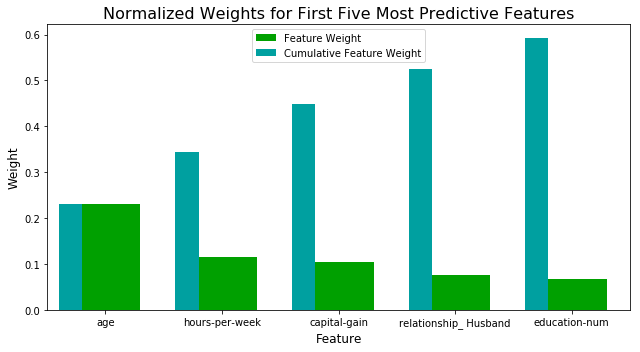

In [31]:
# Train the supervised model on the training set using .fit(X_train, y_train)
model = RandomForestClassifier().fit(X_train, y_train)

# Extract the feature importances using .feature_importances_ 
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

- The top five features are: Age, Hours-per-week, Capital-gain, Relationship_Husband, Education-num. 
- Compare to the five features in Q6, the Age and the Education are included. The other three ones are not close to my thoughts, but they are reasonably important. The hour-per-week could decide the income base, and capital-gain could be a lot more higher than the salary so it impact a lot on the income. The husband earns more in a family than the house womens.

### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below will use the same optimized model you found earlier, and train it on the same training set *with only the top five important features*. 

In [32]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

Final Model trained on full data
------
Accuracy on testing data: 0.8670
F-score on testing data: 0.7455

Final Model trained on reduced data
------
Accuracy on testing data: 0.8454
F-score on testing data: 0.6973


The final model trained on full data is better than trained on reduced data. Maybe it's because the advantages of the Gradient boosting. However, training time is largely reduced. Considering the training time, I would use the reduced data.

In [ ]:
xs